In [1]:
import scipy.io as scio
import h5py
import tifffile as tf
from PIL import Image

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import networkx as nx
from networkx.algorithms import community
import powerlaw
import chart_studio.plotly as py
from plotly.offline import iplot,plot
import plotly.graph_objs as go
import copy
import random

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import entropy
from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import wilcoxon
from itertools import chain

## Settings and Parameters

In [2]:
region_name_dict = {'MBPED':64, 'MBVL':65, 'MBML':66, 'LH':55, 'SLP':72, 'SIP':73, 'CRE':63, 'SCL':84, 'ICL':59,
                 'EB':23, 'FB':26, 'VES':60, 'EPA':85, 'PVLP':76, 'AOTU':79, 'FLA':67, 'IVLP':77}
region_names_reverse = {64: 'MBPED',65: 'MBVL',66: 'MBML',55: 'LH',72: 'SLP',73: 'SIP',74: 'SMP',63: 'CRE',84: 'SCL',59: 'ICL',
                4: 'NO',23: 'EB',26: 'FB',56: 'LAL',79: 'AOTU',75: 'AVLP',76: 'PVLP',77: 'IVLP',60: 'VES',80: 'GOR',82: 'SPS',
                85: 'EPA',67: 'FLA'}

focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67]
print("focus_regions_0:", len(focus_regions_0))

## settings
data_index_list_0 = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                   '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
data_index_list_65 = ['20230420-fly2', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                   '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
data_index_list_73 = ['20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', 
                      '20230510-fly1','20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
data_index_list_84 = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230507-fly1',
                      '20230428-fly1', '20230510-fly1', '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
data_index_list_55 = ['20230417-fly2', '20230420-fly2', '20230420-fly3',  '20230428-fly1',
                      '20230510-fly1','20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']

## path
path_inspur = "xxxx/olfactory_representation/"
print("path_inspur:", path_inspur)

focus_regions_0: 23
path_inspur: //166.111.72.183/sam2p/0-LLB/olfactory_representation/


## Figure 4-i & 4-j & S9-a

----------- processing region:  79  ----- date:  20230428-fly1  -----------------------------
positions: 2496
similarity: (2496, 2496)


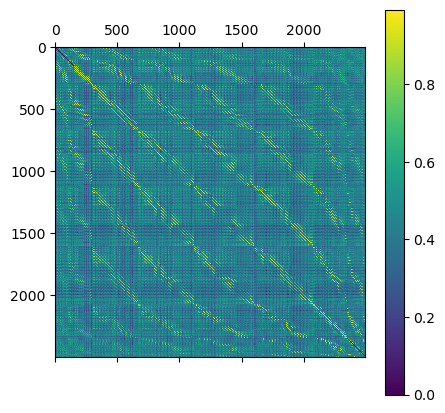

G7f network #node: 2496 #edges: 155751


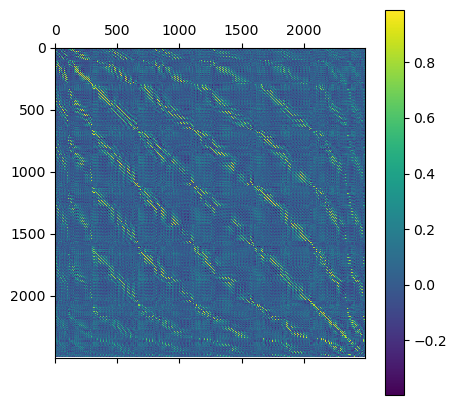

ACh network #node: 2496 #edges: 155751
END


In [92]:
'''
3D functional connectivity network (G7f or ACh) within each region in Stimu stage

'''

## parameters
delete_seg_list = [0.95]
region_index_list = [79]
data_index_list = ['20230428-fly1']

path_save = "F:/THU/drosophila multi-probes/data_analysis_res_revision/single_region_res_overall/3d_network/"

for region_cnt in range(len(region_index_list)):
    
    region_index = region_index_list[region_cnt]
    data_index = data_index_list[region_cnt]
    print("----------- processing region: ", region_index, " ----- date: ", data_index, " -----------------------------")
    
    '''
    G7f network
    '''
    ori_path = path_inspur + 'Ach-' + data_index + '-stimu\\'

    ## load position data
    positions_dict = np.load(ori_path + 'neuron_concat_records\\region_' + str(region_index) + '_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    print("positions:", len(positions))
    
    ## load data
    similarity = np.load(ori_path + 'network/region_' + str(region_index) + '_all_neurons_similarity.npy') 
    n_neurons = len(similarity) 
    print("similarity:", similarity.shape)
                
    ## plot correlation
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.show()
         
#     similarity = np.load(ori_path + 'network\\region_' + str(region_index) + '_all_neurons_similarity.npy',allow_pickle=True)
    similarity_fla = similarity.flatten()
    
    ## delete edges
    delete_seg = delete_seg_list[region_cnt]
    similarity_fla.sort()
    threshold = similarity_fla[int(delete_seg * len(similarity_fla))]

    weighted_edges = [] 
    pos_3d = {}
    n_neurons = len(similarity)
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i]
        for j in range(i + 1, n_neurons):   
            if similarity[i,j] < threshold:
                continue
            weighted_edges.append(np.array([i,j, np.round(similarity[i,j],3)]))
            if j not in pos_3d:
                pos_3d[j] = positions[j]            

    ## generate network
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("G7f network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
       
    ## extract node positions from the layout 
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    ## detect communities
    asyn_partition = list(community.louvain_communities(G, weight='weight'))
    node_par = {}
    for i in range(len(list(asyn_partition))):
        nodes = list(list(asyn_partition)[i])
        for node in nodes:
            node_par[node] = i
    group = np.array([node_par[v] for v in sorted(G)])
    
    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (G7f) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)
    plot(fig, filename = path_save + 'calc_network_region_' + str(region_index) + '_colored_by_community_' + data_index + '.html')

    
    
    '''
    ACh network
    '''
    ori_path = path_inspur + 'Ach-' + data_index + '-trans-stimu\\'

    ## load position data
    positions_dict = np.load(ori_path +'neuron_concat_records\\region_' + str(region_index) +'_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    
    ## load data
    similarity = np.load(ori_path + 'network/region_' + str(region_index) + '_all_neurons_similarity.npy') 
    n_neurons = len(similarity) 
    
    ## plot correlation
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.show()

#     similarity = np.load(ori_path + 'network\\region_' + str(region_index) +'_all_neurons_similarity.npy',allow_pickle=True)
    similarity_fla = similarity.flatten()

    ## delete edges
    delete_seg = delete_seg_list[region_cnt]
    similarity_fla.sort()
    threshold = similarity_fla[int(delete_seg * len(similarity_fla))]
    weighted_edges = [] 
    pos_3d = {}
    n_neurons = len(similarity)
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i]
        for j in range(i + 1, n_neurons):   
            if similarity[i,j] < threshold:
                continue
            weighted_edges.append(np.array([i,j, np.round(similarity[i,j],3)]))
            if j not in pos_3d:
                pos_3d[j] = positions[j]   
    
    ## generate network
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("ACh network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
       
    ## extract edge positions from the layout 
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    ## detect comunities
    asyn_partition = list(community.louvain_communities(G, weight='weight'))
    node_par = {}
    for i in range(len(list(asyn_partition))):
        nodes = list(list(asyn_partition)[i])
        for node in nodes:
            node_par[node] = i
    group = np.array([node_par[v] for v in sorted(G)])

    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (Ach) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)
    plot(fig, filename = path_save + 'ach_network_region_' + str(region_index) + '_colored_by_community_' + data_index + '.html')

print("END")

In [174]:
'''
3D functional connectivity network (Delta) within each region in Stimu stage
'''

## parameters
delete_seg_list = [0.004]
region_index_list = [55]
data_index_list = ['20230510-fly2']

path_save = "F:/THU/drosophila multi-probes/data_analysis_res_revision/single_region_res_overall/3d_network/"

for region_cnt in range(len(data_index_list)):
    region_index = region_index_list[region_cnt]
    data_index = data_index_list[region_cnt]
    print("----------- processing region: ", region_index, " ----- date: ", data_index, " -----------------------------")

    ## load position data
    ori_path = path_inspur + 'Ach-' + data_index + '-stimu\\' 
    positions_dict = np.load(ori_path +'neuron_concat_records\\region_' + str(region_index) +'_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    
    ## load correlation matrix
    ori_path = path_inspur + 'Ach-' + data_index + '-stimu\\'
    A1 = np.load(ori_path + "network\\region_" + str(region_index) + "_all_neurons_similarity.npy")
    A1 = np.nan_to_num(A1)
    A1_avg = np.full((len(A1), len(A1)), np.mean(A1))
    A1_delta = A1 - A1_avg
    A1_delta = A1_delta / A1_avg

    ori_path = path_inspur + 'Ach-' + data_index + '-trans-stimu\\'
    A2 = np.load(ori_path + "network\\region_" + str(region_index) + "_all_neurons_similarity.npy")
    A2 = np.nan_to_num(A2)
    A2_avg = np.full((len(A2), len(A2)), np.mean(A2))
    A2_delta = A2 - A2_avg
    A2_delta = A2_delta / A2_avg
        
    ## calculate the difference
    dff_similarity = A2_delta - A1_delta
    dff_similarity = np.nan_to_num(dff_similarity)
    
    ## delete edges
    n_neurons = len(dff_similarity)
    delete_seg = delete_seg_list[region_cnt]
    pos_edges, neg_edges = [], []
    for i in range(n_neurons - 1):
        for j in range(i + 1, n_neurons):  
            w = dff_similarity[i,j]
            if w > 0:
                pos_edges.append(w)
            elif w < 0:
                neg_edges.append(w)
    pos_edges.sort()
    if len(pos_edges) == 0:
        threshold_pos = 0
    else:
        threshold_pos = pos_edges[int((1 - delete_seg) * len(pos_edges))]
    neg_edges.sort()
    threshold_neg = neg_edges[int(delete_seg * len(neg_edges))]
    
    ## select nodes and edges
    weighted_edges_pos = []
    weighted_edges_neg = []
    pos_3d = {}
    nodes = []
    nodes_pos = []
    nodes_neg = []
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i] 
            nodes.append(i)
        for j in range(i + 1, n_neurons):   
            w = dff_similarity[i,j]
            if w > threshold_pos:
                weighted_edges_pos.append(np.array([i,j, np.round(w,3)]))       
                if i not in nodes_pos:
                    nodes_pos.append(i) 
                if j not in nodes_pos:
                    nodes_pos.append(j) 
            elif w < threshold_neg:
                weighted_edges_neg.append(np.array([i,j, np.round(w,3)]))   
                if i not in nodes_neg:
                    nodes_neg.append(i) 
                if j not in nodes_neg:
                    nodes_neg.append(j)
            if j not in pos_3d:
                pos_3d[j] = positions[j] 
                nodes.append(j)
                
    ## generate network
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges_pos)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("Delta network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
        
    ## extract edge positions from the layout  
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    # node colors
    node_par = {}
    for node in nodes:
        if node in nodes_pos:
            node_par[node] = "#F8AC8C"
        else:
            node_par[node] = "#2878B5"
    group = np.array([node_par[v] for v in sorted(G)])
    
    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (Delta) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, #colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)

    plot(fig, filename = path_save + '3Dnetwork_positive_region_' + str(region_index) + '_colored_by_' + data_index + '.html')
        
print("END")

----------- processing region:  55  ----- date:  20230510-fly2  -----------------------------
Delta network #node: 371 #edges: 106
END


## Figure  S9-b

----------- processing region:  66  ----- date:  20230510-fly2  -----------------------------
positions: 3166
similarity: (3166, 3166)


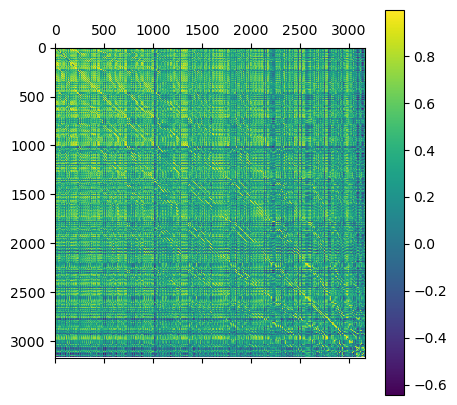

G7f network #node: 3166 #edges: 501178


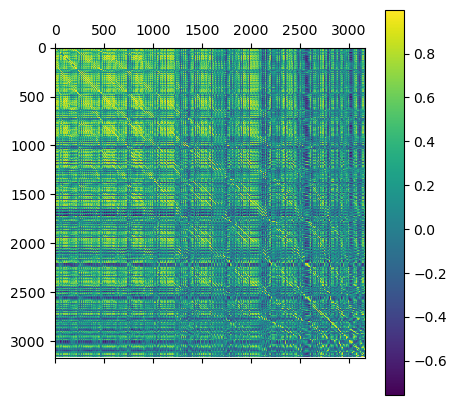

ACh network #node: 3165 #edges: 501178
----------- processing region:  73  ----- date:  20230510-fly2  -----------------------------
positions: 2172
similarity: (2172, 2172)


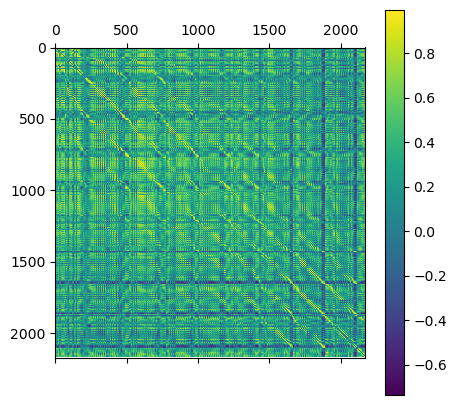

G7f network #node: 2172 #edges: 235880


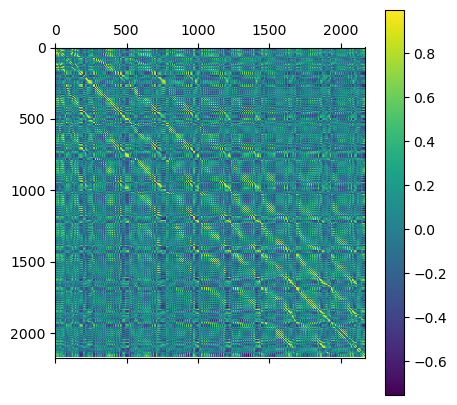

ACh network #node: 2172 #edges: 235880
----------- processing region:  84  ----- date:  20230510-fly2  -----------------------------
positions: 578
similarity: (578, 578)


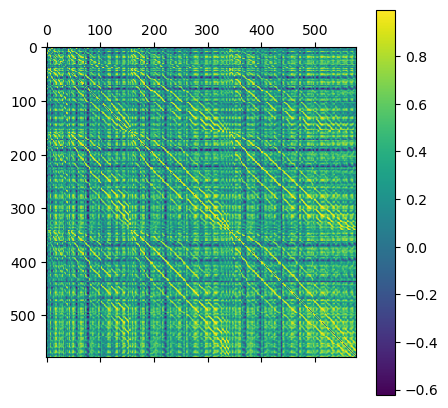

G7f network #node: 578 #edges: 50113


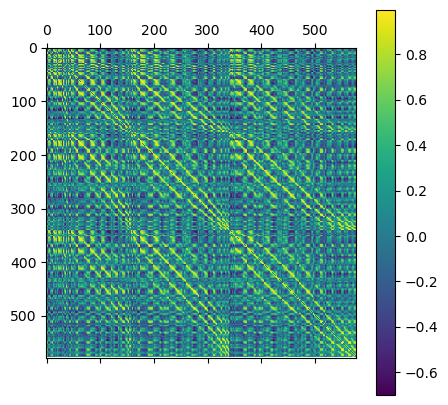

ACh network #node: 578 #edges: 50113
----------- processing region:  23  ----- date:  20230510-fly2  -----------------------------
positions: 2453
similarity: (2453, 2453)


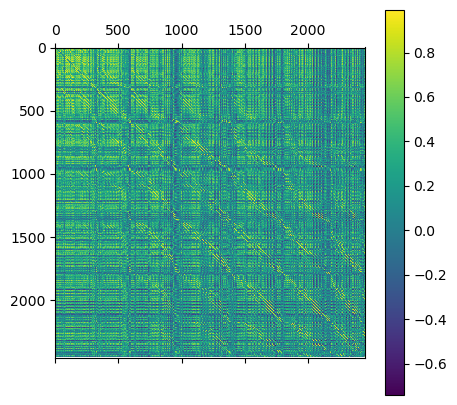

G7f network #node: 2453 #edges: 150431


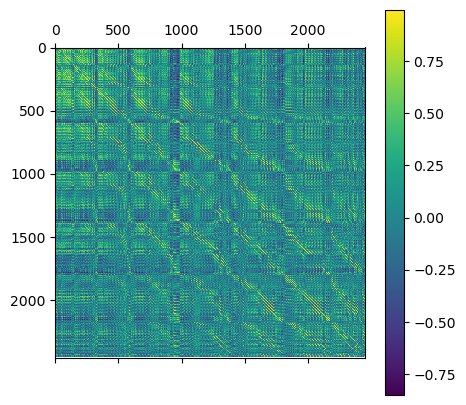

ACh network #node: 2453 #edges: 150431
----------- processing region:  55  ----- date:  20230510-fly2  -----------------------------
positions: 371
similarity: (371, 371)


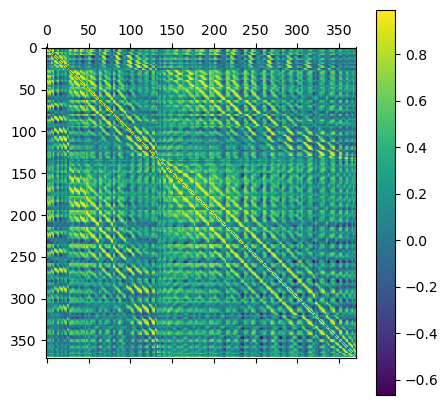

G7f network #node: 371 #edges: 20647


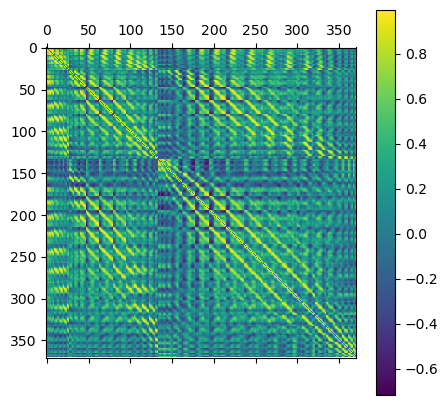

ACh network #node: 371 #edges: 20647
----------- processing region:  85  ----- date:  20230428-fly1  -----------------------------
positions: 352
similarity: (352, 352)


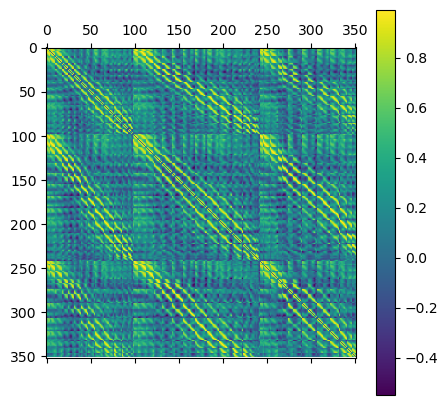

G7f network #node: 352 #edges: 18586


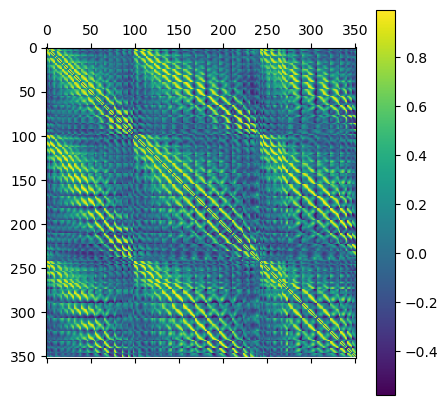

ACh network #node: 352 #edges: 18586
----------- processing region:  79  ----- date:  20230428-fly1  -----------------------------
positions: 2496
similarity: (2496, 2496)


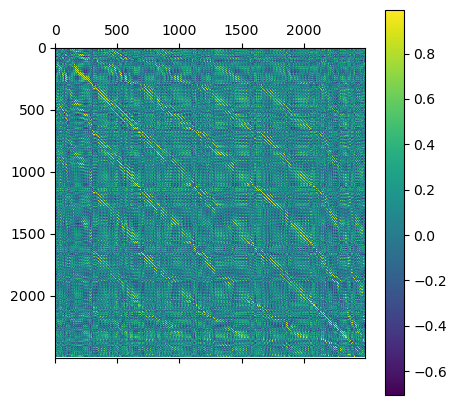

G7f network #node: 2496 #edges: 155751


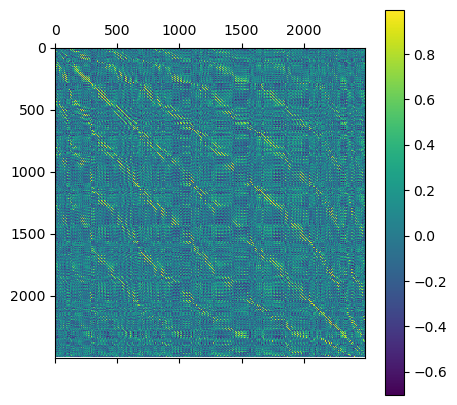

ACh network #node: 2496 #edges: 155751
END


In [93]:
'''
3D functional connectivity network (G7f or ACh) within each region in Stimu stage

'''

## parameters
delete_seg_list = [0.9,0.9,0.7,0.95,0.7,0.7,0.95]
region_index_list = [66,73,84,23,55,85,79]
data_index_list = ['20230510-fly2','20230510-fly2','20230510-fly2','20230510-fly2','20230510-fly2','20230428-fly1','20230428-fly1']

path_save = "F:/THU/drosophila multi-probes/data_analysis_res_revision/single_region_res_overall/3d_network/"

for region_cnt in range(len(region_index_list)):
    
    region_index = region_index_list[region_cnt]
    data_index = data_index_list[region_cnt]
    print("----------- processing region: ", region_index, " ----- date: ", data_index, " -----------------------------")
    
    '''
    G7f network
    '''
    ori_path = path_inspur + 'Ach-' + data_index + '-pre_stimu\\'

    ## load position data
    positions_dict = np.load(ori_path + 'neuron_concat_records\\region_' + str(region_index) + '_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    print("positions:", len(positions))
    
    ## load data
    similarity = np.load(ori_path + 'network/region_' + str(region_index) + '_all_neurons_similarity.npy') 
    n_neurons = len(similarity) 
    print("similarity:", similarity.shape)
                
    ## plot correlation
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.show()
         
#     similarity = np.load(ori_path + 'network\\region_' + str(region_index) + '_all_neurons_similarity.npy',allow_pickle=True)
    similarity_fla = similarity.flatten()
    
    ## delete edges
    delete_seg = delete_seg_list[region_cnt]
    similarity_fla.sort()
    threshold = similarity_fla[int(delete_seg * len(similarity_fla))]

    weighted_edges = [] 
    pos_3d = {}
    n_neurons = len(similarity)
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i]
        for j in range(i + 1, n_neurons):   
            if similarity[i,j] < threshold:
                continue
            weighted_edges.append(np.array([i,j, np.round(similarity[i,j],3)]))
            if j not in pos_3d:
                pos_3d[j] = positions[j]            

    ## generate network
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("G7f network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
       
    ## extract node positions from the layout 
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    ## detect communities
    asyn_partition = list(community.louvain_communities(G, weight='weight'))
    node_par = {}
    for i in range(len(list(asyn_partition))):
        nodes = list(list(asyn_partition)[i])
        for node in nodes:
            node_par[node] = i
    group = np.array([node_par[v] for v in sorted(G)])
    
    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (G7f) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)
    plot(fig, filename = path_save + 'calc_network_region_' + str(region_index) + '_colored_by_community_' + data_index + '_RS.html')

    
    
    '''
    ACh network
    '''
    ori_path = path_inspur + 'Ach-' + data_index + '-trans-pre_stimu\\'

    ## load position data
    positions_dict = np.load(ori_path +'neuron_concat_records\\region_' + str(region_index) +'_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    
    ## load data
    similarity = np.load(ori_path + 'network/region_' + str(region_index) + '_all_neurons_similarity.npy') 
    n_neurons = len(similarity) 
    
    ## plot correlation
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.show()

#     similarity = np.load(ori_path + 'network\\region_' + str(region_index) +'_all_neurons_similarity.npy',allow_pickle=True)
    similarity_fla = similarity.flatten()

    ## delete edges
    delete_seg = delete_seg_list[region_cnt]
    similarity_fla.sort()
    threshold = similarity_fla[int(delete_seg * len(similarity_fla))]
    weighted_edges = [] 
    pos_3d = {}
    n_neurons = len(similarity)
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i]
        for j in range(i + 1, n_neurons):   
            if similarity[i,j] < threshold:
                continue
            weighted_edges.append(np.array([i,j, np.round(similarity[i,j],3)]))
            if j not in pos_3d:
                pos_3d[j] = positions[j]   
    
    ## generate network
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("ACh network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
       
    ## extract edge positions from the layout 
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    ## detect comunities
    asyn_partition = list(community.louvain_communities(G, weight='weight'))
    node_par = {}
    for i in range(len(list(asyn_partition))):
        nodes = list(list(asyn_partition)[i])
        for node in nodes:
            node_par[node] = i
    group = np.array([node_par[v] for v in sorted(G)])

    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (Ach) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)
    plot(fig, filename = path_save + 'ach_network_region_' + str(region_index) + '_colored_by_community_' + data_index + '_RS.html')

print("END")

In [164]:
'''
3D functional connectivity network (Delta) within each region in RS stage
'''

## parameters
delete_seg_list = [0.024]
region_index_list = [85]
data_index_list = ['20230428-fly1']

path_save = "F:/THU/drosophila multi-probes/data_analysis_res_revision/single_region_res_overall/3d_network/"

for region_cnt in range(len(data_index_list)):
    region_index = region_index_list[region_cnt]
    data_index = data_index_list[region_cnt]
    print("----------- processing region: ", region_index, " ----- date: ", data_index, " -----------------------------")

    ## load position data
    ori_path = path_inspur + 'Ach-' + data_index + '-pre_stimu\\' 
    positions_dict = np.load(ori_path +'neuron_concat_records\\region_' + str(region_index) +'_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    
    ## load correlation matrix
    ori_path = path_inspur + 'Ach-' + data_index + '-pre_stimu\\'
    A1 = np.load(ori_path + "network\\region_" + str(region_index) + "_all_neurons_similarity.npy")
    A1 = np.nan_to_num(A1)
    A1_avg = np.full((len(A1), len(A1)), np.mean(A1))
    A1_delta = A1 - A1_avg
    A1_delta = A1_delta / A1_avg

    ori_path = path_inspur + 'Ach-' + data_index + '-trans-pre_stimu\\'
    A2 = np.load(ori_path + "network\\region_" + str(region_index) + "_all_neurons_similarity.npy")
    A2 = np.nan_to_num(A2)
    A2_avg = np.full((len(A2), len(A2)), np.mean(A2))
    A2_delta = A2 - A2_avg
    A2_delta = A2_delta / A2_avg
        
    ## calculate the difference
    dff_similarity = A2_delta - A1_delta
    dff_similarity = np.nan_to_num(dff_similarity)
    
    ## delete edges
    n_neurons = len(dff_similarity)
    delete_seg = delete_seg_list[region_cnt]
    pos_edges, neg_edges = [], []
    for i in range(n_neurons - 1):
        for j in range(i + 1, n_neurons):  
            w = dff_similarity[i,j]
            if w > 0:
                pos_edges.append(w)
            elif w < 0:
                neg_edges.append(w)
    pos_edges.sort()
    if len(pos_edges) == 0:
        threshold_pos = 0
    else:
        threshold_pos = pos_edges[int((1 - delete_seg) * len(pos_edges))]
    neg_edges.sort()
    threshold_neg = neg_edges[int(delete_seg * len(neg_edges))]
    
    ## select nodes and edges
    weighted_edges_pos = []
    weighted_edges_neg = []
    pos_3d = {}
    nodes = []
    nodes_pos = []
    nodes_neg = []
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i] 
            nodes.append(i)
        for j in range(i + 1, n_neurons):   
            w = dff_similarity[i,j]
            if w > threshold_pos:
                weighted_edges_pos.append(np.array([i,j, np.round(w,3)]))       
                if i not in nodes_pos:
                    nodes_pos.append(i) 
                if j not in nodes_pos:
                    nodes_pos.append(j) 
            elif w < threshold_neg:
                weighted_edges_neg.append(np.array([i,j, np.round(w,3)]))   
                if i not in nodes_neg:
                    nodes_neg.append(i) 
                if j not in nodes_neg:
                    nodes_neg.append(j)
            if j not in pos_3d:
                pos_3d[j] = positions[j] 
                nodes.append(j)
                
    ## generate network
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges_pos)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("Delta network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
        
    ## extract edge positions from the layout  
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    # node colors
    node_par = {}
    for node in nodes:
        if node in nodes_pos:
            node_par[node] = "#F8AC8C"
        else:
            node_par[node] = "#2878B5"
    group = np.array([node_par[v] for v in sorted(G)])
    
    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (Delta) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, #colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)

    plot(fig, filename = path_save + '3Dnetwork_RS_positive_region_' + str(region_index) + '_colored_by_' + data_index + '.html')
        
print("END")

----------- processing region:  85  ----- date:  20230428-fly1  -----------------------------
Delta network #node: 352 #edges: 755
END


## Figure S8-i & S8-j 

----------- processing region:  66  ----- date:  20230513-r5HT1.0-fly1  -----------------------------
positions: 3244
sample_neurons: 3000 [0, 1, 3, 4, 5] 3000 (3000, 3000)
similarity: (3000, 3000)


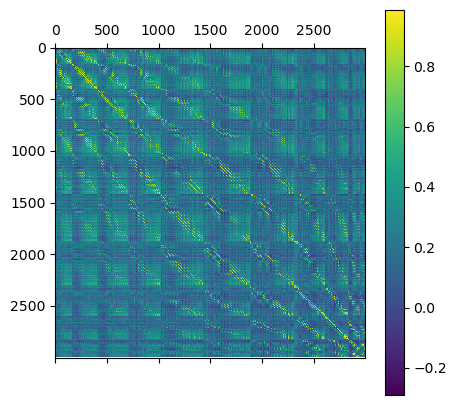

G7f network #node: 3000 #edges: 450000
sample_neurons: 3000 [0 1 3 4 5] 3000 (3000, 3000)


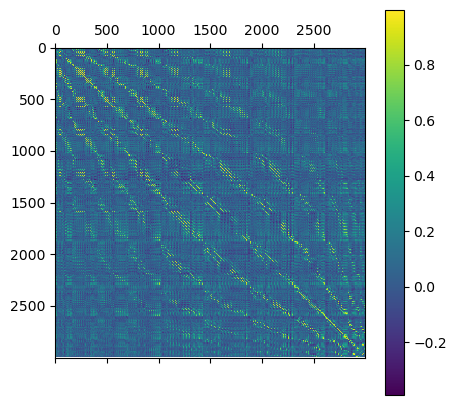

ACh network #node: 3000 #edges: 450000
END


In [103]:
'''
3D functional connectivity network (G7f or ACh) within each region in Stimu stage

'''

## parameters
delete_seg_list = [0.9,0.7]
region_index_list = [66,55]
data_index_list = ['20230513-r5HT1.0-fly1','20230513-r5HT1.0-fly1']

n_sample = 3000

path_save = "F:/THU/drosophila multi-probes/data_analysis_res_revision/single_region_res_overall/3d_network/"

for region_cnt in [0]:#range(len(region_index_list)):
    
    region_index = region_index_list[region_cnt]
    data_index = data_index_list[region_cnt]
    print("----------- processing region: ", region_index, " ----- date: ", data_index, " -----------------------------")
    
    '''
    G7f network
    '''
    ori_path = path_inspur + data_index + '-stimu\\'

    ## load position data
    positions_dict = np.load(ori_path + 'neuron_concat_records\\region_' + str(region_index) + '_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    print("positions:", len(positions))
    
    ## load data
    similarity = np.load(ori_path + 'network/region_' + str(region_index) + '_all_neurons_similarity.npy') 
    if len(similarity) > n_sample:
        sample_neurons = random.sample([i for i in range(len(similarity))],n_sample)
        sample_neurons.sort()
        positions = [positions[i] for i in sample_neurons]
        similarity_new = np.zeros((n_sample,n_sample))
        for i in range(n_sample - 1):
            for j in range(i + 1, n_sample):
                similarity_new[i,j] = similarity_new[j,i] = similarity[sample_neurons[i], sample_neurons[j]]
        print("sample_neurons:", len(sample_neurons), sample_neurons[:5],len(positions), similarity_new.shape)
        np.save(path_save + 'calc_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_ids_sample' + str(n_sample) + '.npy',sample_neurons)
        np.save(path_save + 'calc_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_similarity_sample' + str(n_sample) + '.npy',similarity_new)
        np.save(path_save + 'calc_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_positions_sample' + str(n_sample) + '.npy',positions)
        similarity = similarity_new
    n_neurons = len(similarity) 
    print("similarity:", similarity.shape)
                
    ## plot correlation
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.show()
         
#     similarity = np.load(ori_path + 'network\\region_' + str(region_index) + '_all_neurons_similarity.npy',allow_pickle=True)
    similarity_fla = similarity.flatten()
    
    ## delete edges
    delete_seg = delete_seg_list[region_cnt]
    similarity_fla.sort()
    threshold = similarity_fla[int(delete_seg * len(similarity_fla))]

    weighted_edges = [] 
    pos_3d = {}
    n_neurons = len(similarity)
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i]
        for j in range(i + 1, n_neurons):   
            if similarity[i,j] < threshold:
                continue
            weighted_edges.append(np.array([i,j, np.round(similarity[i,j],3)]))
            if j not in pos_3d:
                pos_3d[j] = positions[j]            

    ## generate network
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("G7f network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
       
    ## extract node positions from the layout 
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    ## detect communities
    asyn_partition = list(community.louvain_communities(G, weight='weight'))
    node_par = {}
    for i in range(len(list(asyn_partition))):
        nodes = list(list(asyn_partition)[i])
        for node in nodes:
            node_par[node] = i
    group = np.array([node_par[v] for v in sorted(G)])
    
    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (G7f) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)
    plot(fig, filename = path_save + 'calc_network_region_' + str(region_index) + '_colored_by_community_' + data_index + '.html')

    
    
    '''
    ACh network
    '''
    ori_path = path_inspur + data_index + '-trans-stimu\\'

    ## load position data
    positions_dict = np.load(ori_path +'neuron_concat_records\\region_' + str(region_index) +'_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    
    ## load data
    similarity = np.load(ori_path + 'network/region_' + str(region_index) + '_all_neurons_similarity.npy') 
    if len(similarity) > n_sample:
        sample_neurons = np.load(path_save + 'calc_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_ids_sample' + str(n_sample) + '.npy')
        positions = [positions[i] for i in sample_neurons]
        similarity_new = np.zeros((n_sample,n_sample))
        for i in range(n_sample - 1):
            for j in range(i + 1, n_sample):
                similarity_new[i,j] = similarity_new[j,i] = similarity[sample_neurons[i], sample_neurons[j]]
        print("sample_neurons:", len(sample_neurons), sample_neurons[:5],len(positions), similarity_new.shape)
        np.save(path_save + '5ht_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_similarity_sample' + str(n_sample) + '.npy',similarity_new)
        np.save(path_save + '5ht_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_positions_sample' + str(n_sample) + '.npy',positions)
        similarity = similarity_new
    n_neurons = len(similarity) 
    
    ## plot correlation
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(111) 
    caxes = axes.matshow(similarity, interpolation ='nearest') 
    figure.colorbar(caxes) 
    plt.show()

#     similarity = np.load(ori_path + 'network\\region_' + str(region_index) +'_all_neurons_similarity.npy',allow_pickle=True)
    similarity_fla = similarity.flatten()

    ## delete edges
    delete_seg = delete_seg_list[region_cnt]
    similarity_fla.sort()
    threshold = similarity_fla[int(delete_seg * len(similarity_fla))]
    weighted_edges = [] 
    pos_3d = {}
    n_neurons = len(similarity)
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i]
        for j in range(i + 1, n_neurons):   
            if similarity[i,j] < threshold:
                continue
            weighted_edges.append(np.array([i,j, np.round(similarity[i,j],3)]))
            if j not in pos_3d:
                pos_3d[j] = positions[j]   
    
    ## generate network
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("ACh network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
       
    ## extract edge positions from the layout 
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    ## detect comunities
    asyn_partition = list(community.louvain_communities(G, weight='weight'))
    node_par = {}
    for i in range(len(list(asyn_partition))):
        nodes = list(list(asyn_partition)[i])
        for node in nodes:
            node_par[node] = i
    group = np.array([node_par[v] for v in sorted(G)])

    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (Ach) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)
    plot(fig, filename = path_save + 'ach_network_region_' + str(region_index) + '_colored_by_community_' + data_index + '.html')

print("END")

In [115]:
'''
3D functional connectivity network (Delta) within each region in RS stage

'''

## parameters
delete_seg_list = [0.0022,0.0052]
region_index_list = [66,55]
data_index_list = ['20230513-r5HT1.0-fly1','20230513-r5HT1.0-fly1']

n_sample = 3000

path_save = "F:/THU/drosophila multi-probes/data_analysis_res_revision/single_region_res_overall/3d_network/"

for region_cnt in range(len(data_index_list)):
    region_index = region_index_list[region_cnt]
    data_index = data_index_list[region_cnt]
    print("----------- processing region: ", region_index, " ----- date: ", data_index, " -----------------------------")

    ## load position data
    ori_path = path_inspur + data_index + '-stimu\\' 
    positions_dict = np.load(ori_path +'neuron_concat_records\\region_' + str(region_index) +'_neuron_positions.npy',allow_pickle=True).item()
    positions = []
    for k,v in positions_dict.items():
        for x_y in v:
            positions.append((x_y[0], x_y[1], k))
    ori_neurons = len(positions)
    
    ## load correlation matrix
    ori_path = path_inspur + data_index + '-stimu\\'
    if ori_neurons > n_sample:
        A1 = np.load(path_save + 'calc_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_similarity_sample' + str(n_sample) + '.npy')
        positions = np.load(path_save + 'calc_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_positions_sample' + str(n_sample) + '.npy')
    else:
        A1 = np.load(ori_path + "network\\region_" + str(region_index) + "_all_neurons_similarity.npy")
    A1 = np.nan_to_num(A1)
    A1_avg = np.full((len(A1), len(A1)), np.mean(A1))
    A1_delta = A1 - A1_avg
    A1_delta = A1_delta / A1_avg

    ori_path = path_inspur + data_index + '-trans-stimu\\'
    if ori_neurons > n_sample:
        A2 = np.load(path_save + '5ht_network_region_' + str(region_index) + '_' + data_index + '_all_neurons_similarity_sample' + str(n_sample) + '.npy')
    else:
        A2 = np.load(ori_path + "network\\region_" + str(region_index) + "_all_neurons_similarity.npy")
    A2 = np.nan_to_num(A2)
    A2_avg = np.full((len(A2), len(A2)), np.mean(A2))
    A2_delta = A2 - A2_avg
    A2_delta = A2_delta / A2_avg
        
    ## calculate the difference
    dff_similarity = A2_delta - A1_delta
    dff_similarity = np.nan_to_num(dff_similarity)
    
    ## delete edges
    n_neurons = len(dff_similarity)
    delete_seg = delete_seg_list[region_cnt]
    pos_edges, neg_edges = [], []
    for i in range(n_neurons - 1):
        for j in range(i + 1, n_neurons):  
            w = dff_similarity[i,j]
            if w > 0:
                pos_edges.append(w)
            elif w < 0:
                neg_edges.append(w)
    pos_edges.sort()
    if len(pos_edges) == 0:
        threshold_pos = 0
    else:
        threshold_pos = pos_edges[int((1 - delete_seg) * len(pos_edges))]
    neg_edges.sort()
    threshold_neg = neg_edges[int(delete_seg * len(neg_edges))]
    
    ## select nodes and edges
    weighted_edges_pos = []
    weighted_edges_neg = []
    pos_3d = {}
    nodes = []
    nodes_pos = []
    nodes_neg = []
    for i in range(n_neurons - 1):
        if i not in pos_3d:
            pos_3d[i] = positions[i] 
            nodes.append(i)
        for j in range(i + 1, n_neurons):   
            w = dff_similarity[i,j]
            if w > threshold_pos:
                weighted_edges_pos.append(np.array([i,j, np.round(w,3)]))       
                if i not in nodes_pos:
                    nodes_pos.append(i) 
                if j not in nodes_pos:
                    nodes_pos.append(j) 
            elif w < threshold_neg:
                weighted_edges_neg.append(np.array([i,j, np.round(w,3)]))   
                if i not in nodes_neg:
                    nodes_neg.append(i) 
                if j not in nodes_neg:
                    nodes_neg.append(j)
            if j not in pos_3d:
                pos_3d[j] = positions[j] 
                nodes.append(j)
                
    ## generate network
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges_pos)
    n_nodes, n_edges = G.number_of_nodes(),G.number_of_edges()
    print("Delta network #node:", n_nodes, "#edges:", n_edges)
    
    ## extract node positions from the layout
    node_xyz = np.array([pos_3d[v] for v in sorted(G)])
    Xn=[]
    Yn=[]
    Zn=[]
    for k in range(len(G.nodes())):
        Xn+=[node_xyz[k][0]]
        Yn+=[node_xyz[k][1]]
        Zn+=[node_xyz[k][2]]
        
    ## extract edge positions from the layout  
    edge_xyz = np.array([(pos_3d[u], pos_3d[v]) for u, v in G.edges()])
    Xe=[]
    Ye=[]
    Ze=[]
    for edge in edge_xyz:
        Xe+=[edge[0][0],edge[1][0],None]
        Ye+=[edge[0][1],edge[1][1],None]
        Ze+=[edge[0][2],edge[1][2],None]

    xaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='x')
    yaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='y')
    zaxis=dict(showbackground=True, showline=False, zeroline=False, showgrid=True, showticklabels=True, title='depth')

    # node colors
    node_par = {}
    for node in nodes:
        if node in nodes_pos:
            node_par[node] = "#F8AC8C"
        else:
            node_par[node] = "#2878B5"
    group = np.array([node_par[v] for v in sorted(G)])
    
    ## plot 3D network
    layout = go.Layout(
             title="Three-dimensional visualization of neural functional network (Delta) in brain region " + str(region_names_reverse[region_index]),
             width=1000,
             height=1000,
             template="none",
             showlegend=False,
             scene=dict(
                 xaxis=dict(xaxis),
                 yaxis=dict(yaxis),
                 zaxis=dict(zaxis),
             xaxis_title = '',
             yaxis_title = '',
             zaxis_title = '',
            ),
            font = dict(color = 'white')
    )
    trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='rgb(125,125,125)', width=0.05), hoverinfo='none')
    trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, mode='markers', name='actors', 
                       marker=dict(symbol='circle', size=10, color=group, #colorscale='Viridis', 
                       line=dict(color='rgb(50,50,50)', width=0.5))) #, hoverinfo='text') # , text=labels
    data=[trace1, trace2]
    fig=go.Figure(data=data, layout=layout)

    plot(fig, filename = path_save + '3Dnetwork_positive_region_' + str(region_index) + '_colored_by_' + data_index + '.html')
        
print("END")

----------- processing region:  66  ----- date:  20230513-r5HT1.0-fly1  -----------------------------
Delta network #node: 3000 #edges: 4393
----------- processing region:  55  ----- date:  20230513-r5HT1.0-fly1  -----------------------------
Delta network #node: 511 #edges: 259
END
